In [11]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


In [13]:
NEG_COMPLIANCE = ["refuses", "noncompliant", "uncooperative", "agitated", "demanding", "difficult"]
POS_COMPLIANCE = ["cooperative", "compliant", "adherent", "follows", "agreeable"]

CLINICAL_CONTENT = ["syndrome", "lab", "troponin", "diagnosis", "catheterization", 
                    "anticoagulation", "treatment", "therapy", "assessment"]

BEHAVIORAL_STYLE = ["appears", "seems", "agitated", "demanding", "emotional", "angry", "upset"]

DISTANCING = ["claims", "alleges", "allegedly", "states", "insists"]
NEUTRAL = ["reports", "notes", "says", "documents"]


In [25]:
import pandas as pd

# Functions
def standardize_ethnicity(x):
    if pd.isna(x):
        return "Other"
    x = x.lower()
    if "white" in x:
        return "White"
    if "black" in x or "african" in x:
        return "Black"
    if "hispanic" in x or "latino" in x:
        return "Hispanic"
    if "asian" in x:
        return "Asian"
    return "Other"

def count_rate(tokens, lexicon):
    count = sum(1 for t in tokens if t in lexicon)
    return count / max(len(tokens), 1)

def load_dataset(path):
    print(f"Loading dataset from: {path}")
    df = pd.read_csv(path)

    # Basic sanity checks
    print(f"Loaded {len(df):,} records")
    print("Columns:", list(df.columns))

    # Make sure required columns exist
    if "TEXT" not in df.columns:
        raise ValueError("ERROR: Dataset is missing 'TEXT' column")
    if "ETHNICITY" not in df.columns:
        raise ValueError("ERROR: Dataset is missing 'ETHNICITY' column")

    # Drop empty text rows
    df = df.dropna(subset=["TEXT"])

    # Standardize ethnicity labels
    df["ETHNICITY"] = df["ETHNICITY"].apply(standardize_ethnicity)

    print(f"After cleaning: {len(df):,} usable notes")
    print("Unique ethnicities:", df["ETHNICITY"].unique())
    return df

# Load the dataset
DATA_PATH = "MIMICIII_Cleaned_Merged.csv"
df = load_dataset(DATA_PATH)


Loading dataset from: MIMICIII_Cleaned_Merged.csv
Loaded 50,000 records
Columns: ['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME', 'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT', 'word_non_compliant', 'word_resistant', 'word_agitated', 'word_uncooperative', 'any_bias_word', 'ETHNICITY', 'GENDER', 'DOB', 'DOD', 'EXPIRE_FLAG']
After cleaning: 50,000 usable notes
Unique ethnicities: ['Other' 'White' 'Hispanic' 'Black' 'Asian']


In [31]:
import re
import pandas as pd

# Function to preprocess text
def preprocess_text(text):
    """
    Lowercase, remove non-alphanumeric characters, and tokenize by whitespace.
    """
    if pd.isna(text):
        return []
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    tokens = text.split()  # simple whitespace tokenizer
    return tokens

# Function to count rate of words in a lexicon
def count_rate(tokens, lexicon):
    """
    Count the proportion of tokens that appear in a given lexicon.
    """
    count = sum(1 for t in tokens if t in lexicon)
    return count / max(len(tokens), 1)

# Example: applying preprocessing and computing rates
# Make sure your dataset 'df' is already loaded

# Apply preprocessing
df['tokens'] = df['TEXT'].apply(preprocess_text)

# Define lexicons
negative_compliance = {"noncompliant", "refuses", "uncooperative", "resistant"}
positive_compliance = {"compliant", "cooperative", "adherent", "engaged"}
behavioral_words = {"agitated", "demanding", "difficult", "pleasant", "helpful"}

# Compute rates
df['neg_compliance_rate'] = df['tokens'].apply(lambda x: count_rate(x, negative_compliance))
df['pos_compliance_rate'] = df['tokens'].apply(lambda x: count_rate(x, positive_compliance))
df['behavior_rate'] = df['tokens'].apply(lambda x: count_rate(x, behavioral_words))

# Check results
print(df[['TEXT', 'neg_compliance_rate', 'pos_compliance_rate', 'behavior_rate']].head())


                                                TEXT  neg_compliance_rate  \
0  Admission Date:  [**2151-7-16**]       Dischar...                  0.0   
1  Admission Date:  [**2118-6-2**]       Discharg...                  0.0   
2  Admission Date:  [**2119-5-4**]              D...                  0.0   
3  Admission Date:  [**2124-7-21**]              ...                  0.0   
4  Admission Date:  [**2162-3-3**]              D...                  0.0   

   pos_compliance_rate  behavior_rate  
0             0.000000       0.000000  
1             0.000000       0.000517  
2             0.000712       0.000000  
3             0.000000       0.000390  
4             0.000478       0.000478  


## Explore distributions by ethnicity

Average rates by ethnicity:
                                                     neg_compliance_rate  \
ETHNICITY                                                                 
AMERICAN INDIAN/ALASKA NATIVE                                  0.000037   
AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNI...             0.000471   
ASIAN                                                          0.000046   
ASIAN - ASIAN INDIAN                                           0.000106   
ASIAN - CAMBODIAN                                              0.000017   
ASIAN - CHINESE                                                0.000037   
ASIAN - FILIPINO                                               0.000000   
ASIAN - JAPANESE                                               0.000000   
ASIAN - KOREAN                                                 0.000029   
ASIAN - OTHER                                                  0.000059   
ASIAN - THAI                                                   0.000000

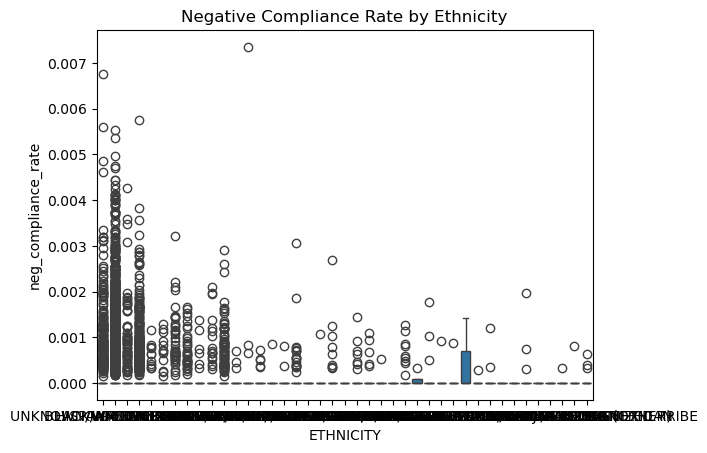

Top 10 notes by negative compliance rate:
                                                     TEXT  neg_compliance_rate
28153  Admission Date:  [**2196-3-3**]              D...             0.007353
160    Admission Date:  [**2195-8-12**]     [**Year (...             0.006768
47297  Admission Date:  [**2141-10-3**]       Dischar...             0.005747
6421   Admission Date:  [**2129-10-14**]       Discha...             0.005602
46757  Admission Date:  [**2102-7-29**]     Discharge...             0.005535
37083  Admission Date:  [**2107-10-8**]       Dischar...             0.005362
45324  Admission Date:  [**2120-3-1**]       Discharg...             0.004975
38918  Admission Date:  [**2201-2-14**]     Discharge...             0.004866
32914  Admission Date:  [**2181-11-24**]             ...             0.004754
7439   Admission Date:  [**2183-7-3**]       Discharg...             0.004708


In [ ]:
import pandas as pd
import re
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import f_oneway

# Load dataset
DATA_PATH = r"C:\Users\kehin\bias_in_clinical_notes\scripts\MIMICIII_Cleaned_Merged.csv"
df = pd.read_csv(DATA_PATH)

# Drop empty TEXT rows
df = df.dropna(subset=['TEXT'])

# Regex-based tokenizer (avoids NLTK punkt issues)
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    tokens = text.split()  # simple whitespace tokenization
    return tokens

# Tokenize all notes
df['tokens'] = df['TEXT'].apply(preprocess_text)

# Function to calculate word rates
def count_rate(tokens, lexicon):
    count = sum(1 for t in tokens if t in lexicon)
    return count / max(len(tokens), 1)

# Define lexicons
negative_compliance = {"noncompliant", "refuses", "uncooperative", "resistant"}
positive_compliance = {"compliant", "cooperative", "adherent", "engaged"}
behavioral_words = {"agitated", "demanding", "difficult", "pleasant", "helpful"}

# Compute rates
df['neg_compliance_rate'] = df['tokens'].apply(lambda x: count_rate(x, negative_compliance))
df['pos_compliance_rate'] = df['tokens'].apply(lambda x: count_rate(x, positive_compliance))
df['behavior_rate'] = df['tokens'].apply(lambda x: count_rate(x, behavioral_words))

# Average rates by ethnicity
ethnicity_stats = df.groupby('ETHNICITY')[['neg_compliance_rate', 'pos_compliance_rate', 'behavior_rate']].mean()
print("Average rates by ethnicity:\n", ethnicity_stats)

# Boxplot for negative compliance rate
sns.boxplot(x='ETHNICITY', y='neg_compliance_rate', data=df)
plt.title("Negative Compliance Rate by Ethnicity")
plt.show()

# Top 10 notes by negative compliance rate
top_neg = df.sort_values('neg_compliance_rate', ascending=False).head(10)
print("Top 10 notes by negative compliance rate:\n", top_neg[['TEXT', 'neg_compliance_rate']])

# TF-IDF representation of text
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(df['TEXT'])

# ANOVA for negative compliance rate
groups = [group['neg_compliance_rate'].values for name, group in df.groupby('ETHNICITY')]
f_stat, p_val = f_oneway(*groups)
print(f"ANOVA F={f_stat}, p={p_val}")


## Statistical Test

In [15]:
import pandas as pd
from scipy.stats import f_oneway
# Load dataset
DATA_PATH = r"C:\Users\kehin\bias_in_clinical_notes\scripts\MIMICIII_Cleaned_Merged.csv"
df = pd.read_csv(DATA_PATH)

# Drop empty TEXT rows
df = df.dropna(subset=['TEXT'])

# Regex-based tokenizer (avoids NLTK punkt issues)
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    tokens = text.split()  # simple whitespace tokenization
    return tokens

# Tokenize all notes
df['tokens'] = df['TEXT'].apply(preprocess_text)

# Function to calculate word rates
def count_rate(tokens, lexicon):
    count = sum(1 for t in tokens if t in lexicon)
    return count / max(len(tokens), 1)

# Define lexicons
negative_compliance = {"noncompliant", "refuses", "uncooperative", "resistant"}
positive_compliance = {"compliant", "cooperative", "adherent", "engaged"}
behavioral_words = {"agitated", "demanding", "difficult", "pleasant", "helpful"}

# Compute rates
df['neg_compliance_rate'] = df['tokens'].apply(lambda x: count_rate(x, negative_compliance))
df['pos_compliance_rate'] = df['tokens'].apply(lambda x: count_rate(x, positive_compliance))
df['behavior_rate'] = df['tokens'].apply(lambda x: count_rate(x, behavioral_words))

# Assuming df is dataframe
groups = [group['neg_compliance_rate'].values for name, group in df.groupby('ETHNICITY')]
f_stat, p_val = f_oneway(*groups)
print(f"F-statistic: {f_stat}, p-value: {p_val}")


F-statistic: 1.553429995172965, p-value: 0.014041788381153834


In [25]:
print(df.columns)


Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME',
       'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT',
       'word_non_compliant', 'word_resistant', 'word_agitated',
       'word_uncooperative', 'any_bias_word', 'ETHNICITY', 'GENDER', 'DOB',
       'DOD', 'EXPIRE_FLAG'],
      dtype='object')


In [ ]:
import pandas as pd
import re
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import f_oneway

# LOAD AND PREPARE DATA

DATA_PATH = r"C:\Users\kehin\bias_in_clinical_notes\scripts\MIMICIII_Cleaned_Merged.csv"
df = pd.read_csv(DATA_PATH)

# Drop empty TEXT rows
df = df.dropna(subset=['TEXT'])

print(f"Loaded {len(df):,} clinical notes")
print(f"\nOriginal ethnicity categories:")
print(df['ETHNICITY'].value_counts())

# ETHNICITY MAPPING TO STANDARD CATEGORIES


def map_ethnicity(ethnicity):
    """Map MIMIC-III ethnicity to standard categories."""
    if pd.isna(ethnicity):
        return 'Unknown'
    
    eth = str(ethnicity).upper()
    
    # White
    if any(x in eth for x in ['WHITE', 'PORTUGUESE', 'BRAZILIAN']):
        return 'White'
    
    # Black/African American
    elif any(x in eth for x in ['BLACK', 'AFRICAN AMERICAN', 'AFRICAN', 'CAPE VERDEAN']):
        return 'Black'
    
    # Hispanic/Latino
    elif any(x in eth for x in ['HISPANIC', 'LATINO', 'CUBAN', 'DOMINICAN', 
                                 'MEXICAN', 'PUERTO RICAN', 'SALVADORAN',
                                 'GUATEMALAN', 'SOUTH AMERICAN', 'CENTRAL AMERICAN']):
        return 'Hispanic'
    
    # Asian/Pacific Islander
    elif any(x in eth for x in ['ASIAN', 'CHINESE', 'FILIPINO', 'VIETNAMESE',
                                 'KOREAN', 'JAPANESE', 'THAI', 'CAMBODIAN',
                                 'HAWAIIAN', 'PACIFIC ISLANDER', 'INDIAN']):
        return 'Asian'
    
    # American Indian/Alaska Native and Other
    elif any(x in eth for x in ['AMERICAN INDIAN', 'ALASKA NATIVE', 'NATIVE AMERICAN']):
        return 'Other'
    
    # Unknown/Declined
    elif any(x in eth for x in ['UNKNOWN', 'UNABLE', 'DECLINE', 'PATIENT DECLINED',
                                'NOT SPECIFIED', 'OTHER']):
        return 'Unknown'
    
    # Multi-racial or any remaining
    else:
        return 'Other'

# Apply mapping
df['ETHNICITY_GROUPED'] = df['ETHNICITY'].apply(map_ethnicity)

print(f"\nGrouped ethnicity distribution:")
print(df['ETHNICITY_GROUPED'].value_counts())
print(f"\nMapping verification (sample):")
print(df[['ETHNICITY', 'ETHNICITY_GROUPED']].drop_duplicates().sort_values('ETHNICITY_GROUPED'))

# TEXT PREPROCESSING

def preprocess_text(text):
    """Tokenize text using regex."""
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s\-]', '', text)  # keep hyphens for compound terms
    tokens = text.split()
    return tokens

# Tokenize all notes
print("\nTokenizing clinical notes...")
df['tokens'] = df['TEXT'].apply(preprocess_text)
df['word_count'] = df['tokens'].apply(len)

# DEFINE LEXICONS (EXPANDED)

# H1: Compliance terms
negative_compliance = {
    "noncompliant", "non-compliant", "nonadherent", "non-adherent",
    "refuses", "refused", "refusing", "refusal",
    "uncooperative", "resistant", "defiant", "difficult",
    "combative", "aggressive", "hostile"
}

positive_compliance = {
    "compliant", "cooperative", "adherent", "cooperating",
    "follows", "following", "agrees", "agreed", "agreeable",
    "engaged", "motivated", "receptive", "willing", "pleasant"
}

# H2: Behavioral/style words
behavioral_words = {
    "agitated", "demanding", "difficult", "pleasant", "helpful",
    "anxious", "angry", "irritable", "dramatic", "emotional",
    "manipulative", "argumentative", "defensive", "paranoid",
    "calm", "friendly", "rude"
}

# H3: Clinical/content words
clinical_words = {
    "diagnosis", "symptom", "symptoms", "procedure", "treatment",
    "medication", "surgery", "laboratory", "imaging", "troponin",
    "catheterization", "syndrome", "infection", "sepsis"
}

# H4: Epistemic markers
distancing_markers = {
    "claims", "claimed", "alleges", "alleged", "allegedly",
    "insists", "insisted", "supposedly", "purportedly",
    "maintains", "asserts"
}

neutral_markers = {
    "reports", "reported", "describes", "described",
    "states", "stated", "notes", "noted", "indicates",
    "presents", "denies", "confirms"
}

# CALCULATE LINGUISTIC FEATURE RATES

def count_rate(tokens, lexicon):
    """Calculate rate per word for a lexicon."""
    count = sum(1 for t in tokens if t in lexicon)
    return count / max(len(tokens), 1)

print("\nCalculating linguistic feature rates...")

df['neg_compliance_rate'] = df['tokens'].apply(lambda x: count_rate(x, negative_compliance))
df['pos_compliance_rate'] = df['tokens'].apply(lambda x: count_rate(x, positive_compliance))
df['behavior_rate'] = df['tokens'].apply(lambda x: count_rate(x, behavioral_words))
df['clinical_rate'] = df['tokens'].apply(lambda x: count_rate(x, clinical_words))
df['distancing_rate'] = df['tokens'].apply(lambda x: count_rate(x, distancing_markers))
df['neutral_rate'] = df['tokens'].apply(lambda x: count_rate(x, neutral_markers))

# TABLE II: GROUPED ETHNICITY STATISTICS

print("\n" + "="*80)
print("TABLE II: LINGUISTIC FEATURE RATES BY ETHNICITY (×10,000)")
print("="*80)

# Calculate statistics for grouped categories
ethnicity_stats = df.groupby('ETHNICITY_GROUPED').agg({
    'neg_compliance_rate': 'mean',
    'pos_compliance_rate': 'mean',
    'behavior_rate': 'mean',
    'clinical_rate': 'mean',
    'distancing_rate': 'mean',
    'ETHNICITY': 'count'  # N
}).round(6)

# Scale by 10,000 for readability
ethnicity_stats_scaled = ethnicity_stats.copy()
for col in ['neg_compliance_rate', 'pos_compliance_rate', 'behavior_rate', 
            'clinical_rate', 'distancing_rate']:
    ethnicity_stats_scaled[col] = ethnicity_stats_scaled[col] * 10000

# Rename columns
ethnicity_stats_scaled.columns = ['Neg_Compliance', 'Pos_Compliance', 'Behavioral', 
                                   'Clinical', 'Distancing', 'N']

# Reorder rows
order = ['White', 'Black', 'Hispanic', 'Asian', 'Other', 'Unknown']
ethnicity_stats_scaled = ethnicity_stats_scaled.reindex(
    [e for e in order if e in ethnicity_stats_scaled.index]
)

print(ethnicity_stats_scaled.round(2))

# Save to CSV
OUTPUT_PATH = r"C:\Users\kehin\bias_in_clinical_notes\results\table2_grouped.csv"
ethnicity_stats_scaled.to_csv(OUTPUT_PATH)
print(f"\nTable saved to: {OUTPUT_PATH}")

# STATISTICAL TESTS (ANOVA)

print("\n" + "="*80)
print("ANOVA TESTS BY ETHNICITY")
print("="*80)

# Exclude 'Unknown' from statistical tests
df_known = df[df['ETHNICITY_GROUPED'] != 'Unknown'].copy()

features_to_test = {
    'neg_compliance_rate': 'H1: Negative Compliance',
    'pos_compliance_rate': 'H1: Positive Compliance',
    'behavior_rate': 'H2: Behavioral Language',
    'clinical_rate': 'H2: Clinical Language',
    'distancing_rate': 'H4: Distancing Markers'
}

for feature, label in features_to_test.items():
    groups = [group[feature].values for name, group in df_known.groupby('ETHNICITY_GROUPED')]
    f_stat, p_val = f_oneway(*groups)
    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
    print(f"{label:30} F = {f_stat:6.2f}, p = {p_val:.6f} {sig}")

# VISUALIZATIONS


print("\nGenerating visualizations...")

# Figure 1: Negative Compliance by Ethnicity
plt.figure(figsize=(10, 6))
order_plot = ['White', 'Black', 'Hispanic', 'Asian', 'Other']
df_plot = df[df['ETHNICITY_GROUPED'].isin(order_plot)]

sns.boxplot(x='ETHNICITY_GROUPED', y='neg_compliance_rate', data=df_plot, order=order_plot)
plt.title("H1: Negative Compliance Rate by Ethnicity", fontsize=14, fontweight='bold')
plt.xlabel("Patient Ethnicity", fontsize=12)
plt.ylabel("Negative Compliance Rate", fontsize=12)
plt.tight_layout()
plt.savefig(r"C:\Users\kehin\bias_in_clinical_notes\figures\neg_compliance_boxplot.png", dpi=300)
plt.show()

# Figure 2: Distancing Markers by Ethnicity
plt.figure(figsize=(10, 6))
sns.boxplot(x='ETHNICITY_GROUPED', y='distancing_rate', data=df_plot, order=order_plot)
plt.title("H4: Distancing Markers by Ethnicity", fontsize=14, fontweight='bold')
plt.xlabel("Patient Ethnicity", fontsize=12)
plt.ylabel("Distancing Rate", fontsize=12)
plt.tight_layout()
plt.savefig(r"C:\Users\kehin\bias_in_clinical_notes\figures\distancing_boxplot.png", dpi=300)
plt.show()


# EXAMPLE NOTES WITH HIGH BIAS INDICATORS


print("\n" + "="*80)
print("EXAMPLE NOTES WITH HIGH NEGATIVE COMPLIANCE")
print("="*80)

# Top notes by negative compliance for Black patients
black_high_neg = df[(df['ETHNICITY_GROUPED'] == 'Black') & 
                    (df['neg_compliance_rate'] > df['neg_compliance_rate'].quantile(0.9))]

if len(black_high_neg) > 0:
    print("\nBlack patient note example:")
    example = black_high_neg.iloc[0]
    print(f"Rate: {example['neg_compliance_rate']:.4f}")
    print(f"Text excerpt: {example['TEXT'][:300]}...")

# Low negative compliance for White patients
white_low_neg = df[(df['ETHNICITY_GROUPED'] == 'White') & 
                   (df['neg_compliance_rate'] < df['neg_compliance_rate'].quantile(0.1))]

if len(white_low_neg) > 0:
    print("\nWhite patient note example (low negative compliance):")
    example = white_low_neg.iloc[0]
    print(f"Rate: {example['neg_compliance_rate']:.4f}")
    print(f"Text excerpt: {example['TEXT'][:300]}...")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)